# A NumPy-Based Demo of Fast Autoregressive Text Generation

This notebook demonstrates a decoder-only transformer model implemented from scratch using NumPy. The implementation includes a KV (Key-Value) cache mechanism that significantly speeds up the autoregressive text generation process.

## Overview

The transformer decoder model in this demonstration:
- A character-level tokenizer for simplicity
- Manual key-value (KV) caching for efficient autoregressive generation
- Performance benchmarking with and without cache
- Interactive components for experimentation

## 1. Configuration & Setup

Define model parameters and import necessary libraries.

In [3]:
import sys
import os

current_dir = os.getcwd()
project_root = current_dir
if os.path.basename(current_dir) in ['src', 'tests', 'notebooks']:
    project_root = os.path.dirname(current_dir)
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Add the src directory to the path so we can import our modules
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import our custom modules
from src.config import get_config
from src.tokenizer import Tokenizer
from src.decoder import Decoder
from src.generation import generate

print("Imports completed successfully!")

# Get the default configuration
config = get_config()

# Override with smaller values for demonstration
config['d_model'] = 128      # Embedding dimension
config['n_layers'] = 3       # Number of decoder layers
config['n_heads'] = 4        # Number of attention heads
config['d_ff'] = 512         # Feed-forward dimension
config['max_seq_len'] = 100  # Maximum sequence length

print("Model Configuration:")
for key, value in config.items():
    print(f"- {key}: {value}")

Imports completed successfully!
Model Configuration:
- vocab_size: 50257
- d_model: 128
- n_layers: 3
- n_heads: 4
- d_ff: 512
- dropout_rate: 0.1
- embed_dropout: 0.1
- attn_dropout: 0.1
- ff_dropout: 0.1
- residual_dropout: 0.1
- max_seq_len: 100
- batch_size: 32
- learning_rate: 0.0003
- num_epochs: 5
- warmup_steps: 2000
- gradient_clip_val: 1.0
- use_kv_cache: True
- epsilon: 1e-05
- d_head: 64


## 2. Tokenizer Setup

Next, we'll set up our character-level tokenizer. For simplicity, we'll use a limited character set.

In [5]:
# Create a sample corpus with common characters
sample_corpus = "abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ 0123456789 .,;!?-\n'"

# Initialize the tokenizer
tokenizer = Tokenizer(sample_corpus)

# Update config with vocabulary size
config['vocab_size'] = tokenizer.vocab_size

print(f"Tokenizer initialized with {tokenizer.vocab_size} characters in vocabulary.")
print(f"Vocabulary: '{sample_corpus}'")

Tokenizer initialized with 71 characters in vocabulary.
Vocabulary: 'abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ 0123456789 .,;!?-
''


Let's test our tokenizer with a simple example:

In [6]:
# Test the tokenizer
test_text = "Hello, world!"
encoded = tokenizer.encode(test_text)
decoded = tokenizer.decode(encoded)

print(f"Original: '{test_text}'")
print(f"Encoded: {encoded}")
print(f"Decoded: '{decoded}'")

Original: 'Hello, world!'
Encoded: [26, 49, 56, 56, 59, 4, 1, 67, 59, 62, 56, 48, 2]
Decoded: 'Hello, world!'


## 3. Transformer Decoder Initialization

Build a single-layer decoder-only transformer using NumPy.

In [7]:
# Initialize the decoder model
model = Decoder(
    vocab_size=config['vocab_size'],
    d_model=config['d_model'],
    n_layers=config['n_layers'],
    n_heads=config['n_heads'],
    d_ff=config['d_ff'],
    max_seq_len=config['max_seq_len'],
    epsilon=config['epsilon']
)

print("Transformer Decoder model initialized successfully.")
print(f"Model structure: {config['n_layers']} layers, {config['n_heads']} attention heads, {config['d_model']} dimensions")

Transformer Decoder model initialized successfully.
Model structure: 3 layers, 4 attention heads, 128 dimensions


## 4. Text Generation

Generate text using the model with and without KV cache.

In [9]:
# Sample prompt for generation
prompt = "The quick brown fox"

# Generate text with different parameters
def generate_and_display(prompt, max_len=20, temperature=1.0, use_kv_cache=True):
    start_time = time.time()
    generated_text = generate(
        model=model,
        tokenizer_instance=tokenizer,
        prompt=prompt,
        max_len=max_len,
        temperature=temperature,
        use_kv_cache=use_kv_cache
    )
    end_time = time.time()
    gen_time = end_time - start_time
    
    print(f"Generated (T={temperature}, KV Cache={'Enabled' if use_kv_cache else 'Disabled'}):\n{generated_text}")
    print(f"Time taken: {gen_time:.4f} seconds")
    
    return gen_time, generated_text

# Generate with default parameters
print(f"Prompt: {prompt}")
time_with_cache, text_with_cache = generate_and_display(prompt, max_len=30, temperature=0.8, use_kv_cache=True)



Prompt: The quick brown fox
Generated (T=0.8, KV Cache=Enabled):
The quick brown fox7mcwJ.gwcGd5w'c!w7wV!5'TT7!6;g
Time taken: 0.0654 seconds


### 4.1 Comparison: Cached vs Non-Cached
Measure and compare performance time and efficiency.

In [10]:
# Generate text with and without KV cache for performance comparison
print("Generating with KV Cache enabled:")
time_with_cache, _ = generate_and_display(prompt, max_len=30, temperature=0.7, use_kv_cache=True)

print("\nGenerating with KV Cache disabled:")
time_without_cache, _ = generate_and_display(prompt, max_len=30, temperature=0.7, use_kv_cache=False)

speedup = time_without_cache / time_with_cache if time_with_cache > 0 else 0
print(f"\nSpeedup with KV Cache: {speedup:.2f}x faster")

Generating with KV Cache enabled:
Generated (T=0.7, KV Cache=Enabled):
The quick brown foxdwHR7TcHwIrwV'74'R;ew-d!;!wgHd
Time taken: 0.0228 seconds

Generating with KV Cache disabled:
Generated (T=0.7, KV Cache=Disabled):
The quick brown foxwww55k5w!ad5!5TlV!!w!w!wBwwW5;
Time taken: 0.4444 seconds

Speedup with KV Cache: 19.45x faster


### 4.2 Visualization
A bar chart shows the runtime difference.

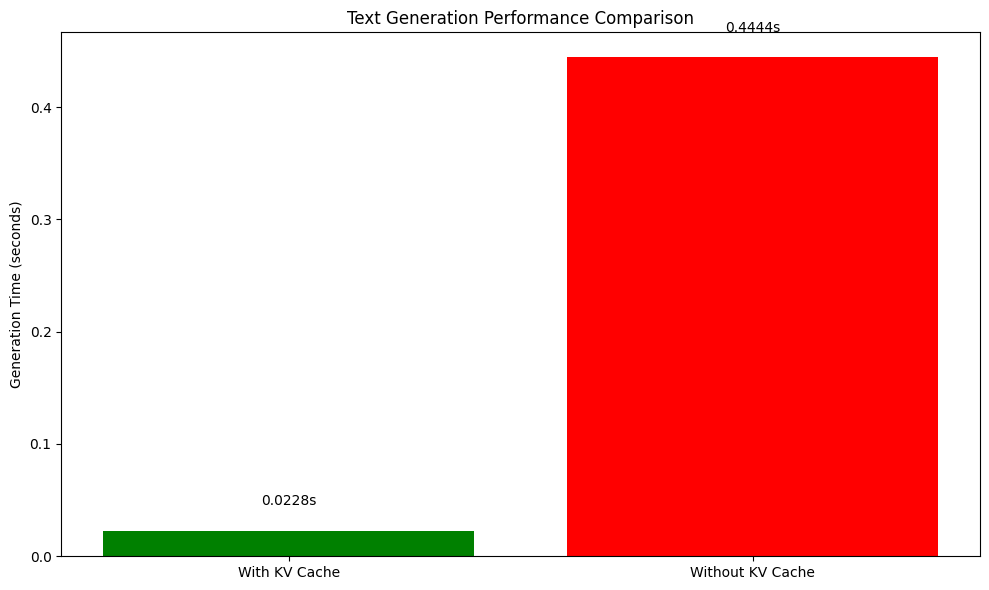

KV Cache provides a 19.45x speedup in text generation!


In [11]:
# Visualize the performance comparison
labels = ['With KV Cache', 'Without KV Cache']
times = [time_with_cache, time_without_cache]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, times, color=['green', 'red'])
plt.ylabel('Generation Time (seconds)')
plt.title('Text Generation Performance Comparison')

# Add time values above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.4f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Display speedup as text
print(f"KV Cache provides a {speedup:.2f}x speedup in text generation!")

## 5. Temperature Effects on Output

Explore how different temperature values impact the diversity of generated text.

In [12]:
# Set a prompt
creative_prompt = "Once upon a time, I went to class at Waterloo"
print(f"Prompt: {creative_prompt}\n")

# Generate with different temperatures
temperatures = [0.0, 0.5, 1.0, 1.5]
for temp in temperatures:
    print(f"Temperature = {temp}:")
    _, generated = generate_and_display(creative_prompt, max_len=40, temperature=temp)
    print("")

Prompt: Once upon a time, I went to class at Waterloo

Temperature = 0.0:
Generated (T=0.0, KV Cache=Enabled):
Once upon a time, I went to class at Waterloowwwwwwwwwwwwwwwddddddddwwwwwwwdwwwwwwwww
Time taken: 0.0349 seconds

Temperature = 0.5:
Generated (T=0.5, KV Cache=Enabled):
Once upon a time, I went to class at WaterlooddwdbddbwdwtdbdddoAor dqsq77kdoHw55q35dk
Time taken: 0.0238 seconds

Temperature = 1.0:
Generated (T=1.0, KV Cache=Enabled):
Once upon a time, I went to class at Waterloog'Sd2Q.bwwbqgwuq 4xf.rH dHU7!sb4k4qu-5ik
Time taken: 0.0232 seconds

Temperature = 1.5:
Generated (T=1.5, KV Cache=Enabled):
Once upon a time, I went to class at Waterloo;5H5URS4a'H5 P5eDIG5Yo7q-T6ddgJ.9Sr;WnAr
Time taken: 0.0237 seconds



## 6. Interactive Text Generation

Now let's create an interactive cell where you can input your own prompt and generation parameters:

In [21]:
# Interactive imports
from ipywidgets import interact, fixed, FloatSlider, IntSlider, Text, Checkbox

# Define interactive generation function
def interactive_generate(prompt, max_len, temperature, use_kv_cache):
    if not prompt:
        return "Please enter a prompt."
    
    start_time = time.time()
    generated_text = generate(
        model=model,
        tokenizer_instance=tokenizer,
        prompt=prompt,
        max_len=max_len,
        temperature=temperature,
        use_kv_cache=use_kv_cache
    )
    end_time = time.time()
    time_taken = end_time - start_time
    
    result = f"Generated Text: {generated_text} | "
    result += f"Generation Time: {time_taken:.4f} seconds | "
    result += f"KV Cache: {'Enabled' if use_kv_cache else 'Disabled'} | "
    result += f"Temperature: {temperature}"
    
    return result

# Create interactive widget
interact(
    interactive_generate,
    prompt=Text(value="Hello, world!", description="Prompt:", style={'description_width': 'initial'}),
    max_len=IntSlider(min=5, max=100, step=5, value=30, description="Generation Length:"),
    temperature=FloatSlider(min=0.0, max=2.0, step=0.1, value=0.7, description="Temperature:"),
    use_kv_cache=Checkbox(value=True, description="Use KV Cache")
);

interactive(children=(Text(value='Hello, world!', description='Prompt:', style=TextStyle(description_width='in…

## 7. Performance Analysis for Different Sequence Lengths

Let's analyze how the performance difference scales with the length of generated text:

In [38]:
# Test performance for various sequence lengths
seq_lengths = [10, 20, 30, 40, 50]
times_with_cache = []
times_without_cache = []

short_prompt = "Test"

for length in seq_lengths:
    print(f"\nTesting with generation length: {length}")
    
    # With KV cache
    start_time = time.time()
    _ = generate(model, tokenizer, short_prompt, length, temperature=0.7, use_kv_cache=True)
    end_time = time.time()
    time_with_cache = end_time - start_time
    times_with_cache.append(time_with_cache)
    print(f"With KV Cache: {time_with_cache:.4f} seconds")
    
    # Without KV cache
    start_time = time.time()
    _ = generate(model, tokenizer, short_prompt, length, temperature=0.7, use_kv_cache=False)
    end_time = time.time()
    time_without_cache = end_time - start_time
    times_without_cache.append(time_without_cache)
    print(f"Without KV Cache: {time_without_cache:.4f} seconds")
    
    speedup = time_without_cache / time_with_cache
    print(f"Speedup: {speedup:.2f}x")


Testing with generation length: 10
With KV Cache: 0.0096 seconds
Without KV Cache: 0.0404 seconds
Speedup: 4.22x

Testing with generation length: 20
With KV Cache: 0.0122 seconds
Without KV Cache: 0.1103 seconds
Speedup: 9.02x

Testing with generation length: 30
With KV Cache: 0.0188 seconds
Without KV Cache: 0.2385 seconds
Speedup: 12.69x

Testing with generation length: 40
With KV Cache: 0.0249 seconds
Without KV Cache: 0.3824 seconds
Speedup: 15.36x

Testing with generation length: 50
With KV Cache: 0.0308 seconds
Without KV Cache: 0.5857 seconds
Speedup: 19.05x


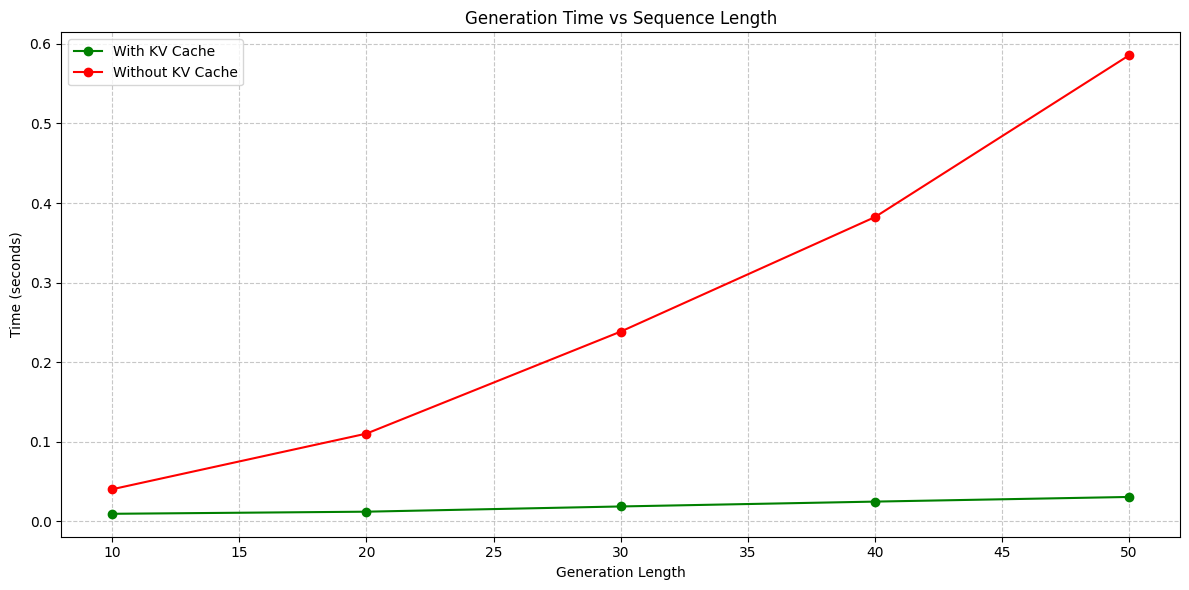

In [39]:
# Plot the performance comparison for different sequence lengths
plt.figure(figsize=(12, 6))

plt.plot(seq_lengths, times_with_cache, 'o-', label='With KV Cache', color='green')
plt.plot(seq_lengths, times_without_cache, 'o-', label='Without KV Cache', color='red')

plt.xlabel('Generation Length')
plt.ylabel('Time (seconds)')
plt.title('Generation Time vs Sequence Length')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

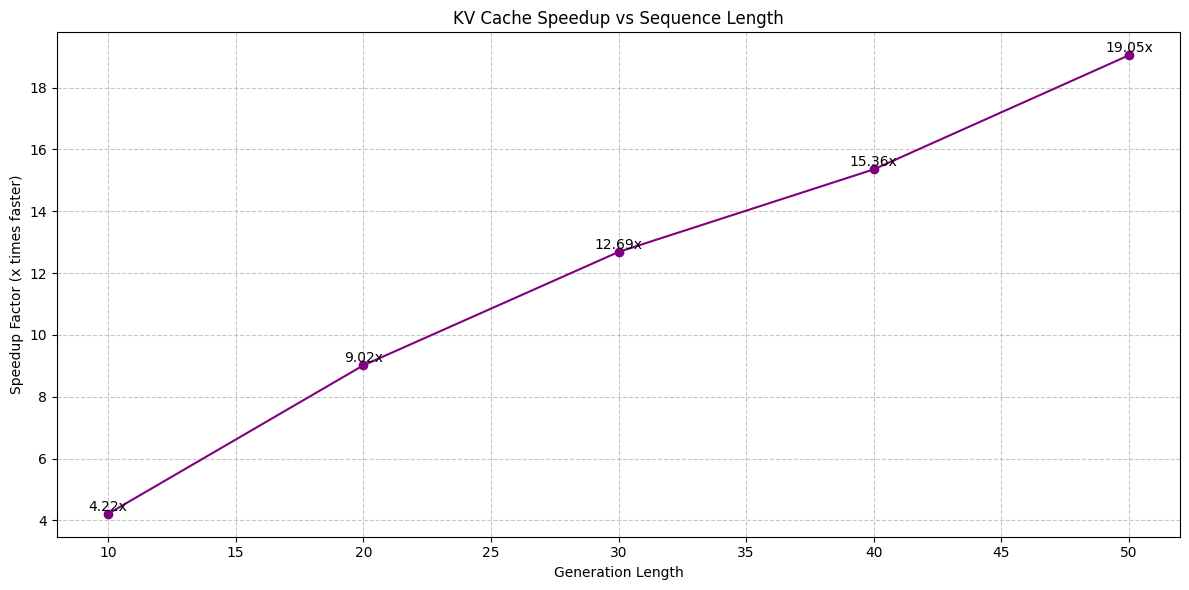

In [40]:
# Calculate and plot speedup factor
speedups = [t_without / t_with for t_with, t_without in zip(times_with_cache, times_without_cache)]

plt.figure(figsize=(12, 6))
plt.plot(seq_lengths, speedups, 'o-', color='purple')
plt.xlabel('Generation Length')
plt.ylabel('Speedup Factor (x times faster)')
plt.title('KV Cache Speedup vs Sequence Length')
plt.grid(True, linestyle='--', alpha=0.7)

# Add text labels above points
for i, speedup in enumerate(speedups):
    plt.text(seq_lengths[i], speedup + 0.1, f'{speedup:.2f}x', ha='center')

plt.tight_layout()
plt.show()

## 8. Attention Visualization

Now, let's visualize the attention mechanism. We'll generate a short sequence and plot the attention weights for a specific head in a specific layer to see what the model focuses on when generating the next token. We will use the KV cache enabled path for this visualization, as it shows what the current query token attends to in the accumulated key/value states.

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

# Assume 'model', 'tokenizer', 'config' are already defined and initialized in your notebook
# Assume 'generate' function from src.generation is imported and available
# from transformer_from_scratch.src.generation import generate
# from transformer_from_scratch.src.tokenizer import Tokenizer
# from transformer_from_scratch.src.decoder import Decoder
# from transformer_from_scratch.src.config import get_config

# Helper function to plot attention heatmap for a specific head and layer
def plot_attention_head(attention_weights, step, layer, head, input_tokens, generated_tokens):
    """
    Plots the attention heatmap for a specific head, layer, and generation step.

    Args:
        attention_weights (list): List of attention weights per step.
                                  Each element is a list of layer attentions.
                                  Each layer attention is a np.ndarray (batch, n_heads, seq_len_q, seq_len_k).
        step (int): The generation step to visualize.
        layer (int): The decoder layer to visualize.
        head (int): The attention head to visualize.
        input_tokens (list): List of input token strings.
        generated_tokens (list): List of generated token strings (up to the current step).
    """
    if not attention_weights:
        print("No attention weights available to plot.")
        return

    if step >= len(attention_weights):
        print(f"Step {step} is out of bounds. Max step is {len(attention_weights) - 1}.")
        return

    step_attention = attention_weights[step]
    if layer >= len(step_attention):
        print(f"Layer {layer} is out of bounds for step {step}. Max layer is {len(step_attention) - 1}.")
        return

    layer_attention = step_attention[layer] # (batch, n_heads, seq_len_q, seq_len_k)

    # Assuming batch_size is 1 for generation
    if layer_attention.ndim == 4 and layer_attention.shape[0] == 1:
        head_attention = layer_attention[0, head, :, :] # (seq_len_q, seq_len_k)
    elif layer_attention.ndim == 3: # For non-KV cache path, it might be (n_heads, seq_len_q, seq_len_k)
        head_attention = layer_attention[head, :, :]
    else:
        print(f"Unexpected attention weights shape: {layer_attention.shape}")
        return

    # seq_len_q is the number of query tokens (usually 1 in KV cache step-by-step, or full sequence in non-KV)
    # seq_len_k is the number of key tokens (full sequence length up to current step)
    
    # For KV cache, seq_len_q is 1 (current token querying previous ones).
    # We are interested in the attention scores for the *last query token* over all key tokens.
    # If not using KV cache, seq_len_q is the full length of the query sequence at that step.
    # The attention_weights from generation.py should be structured as:
    # all_step_attention_weights: list (per gen step) of lists (per layer) of np.arrays (B, H, T_q, T_k)
    # For KV cache path, T_q is 1 at each step after the first.
    # For non-KV cache path, T_q is current_seq_len.
    
    # We want to visualize the attention from the last token of the query sequence
    # to all tokens in the key sequence.
    attention_to_plot = head_attention[-1, :] # Last query token's attention to all key tokens

    # Ensure attention_to_plot is 1D
    if attention_to_plot.ndim > 1:
        attention_to_plot = attention_to_plot.flatten()

    # Determine tokens for x-axis (keys) and y-axis (query)
    # The key tokens are all tokens generated so far (input_tokens + generated_tokens up to 'step')
    # The query token is the token being generated at 'step + 1' (whose attention we are plotting)

    # seq_len_k should match the length of the sequence up to the current generation point
    # The tokens on the x-axis are the "keys" being attended to.
    # These are the input prompt + previously generated tokens.
    key_tokens = input_tokens + generated_tokens[:step+1] # Tokens available as keys

    # The y-axis label is the token whose attention we are visualizing
    # (the one that was just generated, or the one about to be generated, depending on perspective)
    # Let's label it as "Current Query Token" or the actual token if available.
    # For simplicity, we'll use a generic label or the index.
    # `attention_to_plot` has shape (seq_len_k,)
    
    if len(attention_to_plot) != len(key_tokens):
        print(f"Mismatch between attention vector length ({len(attention_to_plot)}) and key_tokens length ({len(key_tokens)}).")
        print("This might happen if the prompt processing step's attention is not handled or shapes are unexpected.")
        # Attempt to plot what we have, might be cropped.
        min_len = min(len(attention_to_plot), len(key_tokens))
        attention_to_plot = attention_to_plot[:min_len]
        key_tokens = key_tokens[:min_len]
        if not key_tokens:
            print("No key tokens to plot.")
            return

    plt.figure(figsize=(max(8, len(key_tokens) * 0.8), 2.5)) # Adjusted figsize
    plt.imshow(attention_to_plot[np.newaxis, :], cmap='viridis', aspect='auto') # Plot as a horizontal strip
    
    plt.xticks(ticks=np.arange(len(key_tokens)), labels=[repr(t) for t in key_tokens], rotation=90)
    plt.yticks([]) # No y-ticks as it's a single query's attention
    
    query_token_label = f"Token at step {step+1}"
    if step < len(generated_tokens):
        query_token_label = f"Query: '{repr(generated_tokens[step])}' (at pos {len(input_tokens) + step})"

    plt.title(f"Attention Heatmap\nLayer {layer}, Head {head} for {query_token_label}")
    plt.xlabel("Key Tokens (Attended To)")
    plt.ylabel(f"Attention from Query", labelpad=20) # Label for the single query row
    plt.colorbar(label="Attention Weight", orientation="vertical", pad=0.02) # Smaller colorbar
    plt.tight_layout()
    plt.show()

# --- Example Usage ---
# This part demonstrates how to get attention weights and use the plotter.
# You'll need to integrate this with your existing notebook structure.

# 1. Define a sample prompt and parameters
sample_prompt = "The cat sat"
max_gen_len = 5
temperature = 0.0 # Greedy for predictable output for visualization
use_kv_cache_viz = True # Or False to test the other path

# 2. Tokenize the prompt
# Assuming `tokenizer` is initialized
# Example:
# corpus = "The cat sat on the mat. The dog barked."
# tokenizer = Tokenizer(corpus)
prompt_tokens = tokenizer.encode(sample_prompt)
prompt_token_strings = [tokenizer.decode([t]) for t in prompt_tokens]

# 3. Generate text and get attention weights
# Ensure your `generate` function is imported and model is loaded
# generated_text, attention_weights = generate(
#     model,
#     tokenizer,
#     prompt=sample_prompt,
#     max_len=max_gen_len,
#     temperature=temperature,
#     use_kv_cache=use_kv_cache_viz,
#     return_attention_weights=True # CRITICAL: This must be True
# )

# For demonstration, let's create dummy attention weights if you can't run generate yet
# Replace this with actual call to `generate`
# Dummy data structure:
# attention_weights = [ # List per generation step
#     [ # List per layer (e.g., 2 layers)
#         np.random.rand(1, config['n_heads'], 1, len(prompt_tokens) + i + 1) for i in range(max_gen_len) # Layer 0, (Batch, Heads, Seq_q=1, Seq_k=len_prompt+step)
#     ] for _ in range(config['n_layers']) # Incorrect structure based on description, fixing below.
# ]
# Corrected dummy data structure:
# all_step_attention_weights: list (per gen step) of lists (per layer) of np.arrays (B, H, T_q, T_k)

if 'model' in locals() and 'tokenizer' in locals() and 'config' in locals() and 'generate' in globals():
    print(f"Generating text with {'KV cache' if use_kv_cache_viz else 'NO KV cache'} to get attention weights...")
    # Ensure generate function is correctly imported from your project structure
    # from transformer_from_scratch.src.generation import generate

    generated_text_viz, all_step_att_weights_viz = generate(
        model,
        tokenizer,
        prompt=sample_prompt,
        max_len=max_gen_len,
        temperature=temperature,
        use_kv_cache=use_kv_cache_viz,
        return_attention_weights=True,
        stop_token_id=tokenizer.char_to_idx.get('.', -1) # Example stop token
    )
    print(f"Generated text: {generated_text_viz}")

    # Extract generated token strings (excluding the prompt part)
    actual_generated_part = generated_text_viz[len(sample_prompt):]
    generated_token_strings_viz = [char for char in actual_generated_part] # Character by character

    if not all_step_att_weights_viz:
        print("Failed to retrieve attention weights. `generate` might not have run correctly or returned empty weights.")
    else:
        print(f"Retrieved {len(all_step_att_weights_viz)} steps of attention weights.")
        if all_step_att_weights_viz:
            first_step_weights = all_step_att_weights_viz[0]
            print(f"Number of layers in first step: {len(first_step_weights)}")
            if first_step_weights:
                first_layer_weights = first_step_weights[0]
                print(f"Shape of first layer attention in first step: {first_layer_weights.shape}")
                # Expected: (batch_size, n_heads, seq_len_q, seq_len_k)
                # seq_len_q will be 1 for KV cache steps after prompt, or full for non-KV
                # seq_len_k will be current total sequence length

    # --- Interactive plotting ---
    # Check if weights were actually returned
    if all_step_att_weights_viz and len(all_step_att_weights_viz) > 0 :
        max_steps_viz = len(all_step_att_weights_viz)
        # Assuming model config is available for n_layers and n_heads
        num_layers_viz = model.n_layers # or config['n_layers']
        num_heads_viz = model.mha_list[0].n_heads if hasattr(model, 'mha_list') and model.mha_list else config.get('n_heads',1) # A way to get n_heads

        step_slider = widgets.IntSlider(value=0, min=0, max=max_steps_viz - 1, step=1, description='Gen Step:')
        layer_slider = widgets.IntSlider(value=0, min=0, max=num_layers_viz - 1, step=1, description='Layer:')
        head_slider = widgets.IntSlider(value=0, min=0, max=num_heads_viz - 1, step=1, description='Head:')
        
        plot_button = widgets.Button(description="Plot Attention")
        
        output_area = widgets.Output()

        def on_plot_button_clicked(b):
            with output_area:
                clear_output(wait=True)
                plot_attention_head(
                    all_step_att_weights_viz,
                    step=step_slider.value,
                    layer=layer_slider.value,
                    head=head_slider.value,
                    input_tokens=prompt_token_strings,
                    generated_tokens=generated_token_strings_viz
                )

        plot_button.on_click(on_plot_button_clicked)

        print("\nUse sliders to select generation step, layer, and head, then click 'Plot Attention'.")
        print("Note: 'Gen Step' refers to the generation of the (step+1)-th new token.")
        display(widgets.VBox([step_slider, layer_slider, head_slider, plot_button, output_area]))
        
        # Initial plot for the first step, layer 0, head 0
        with output_area:
            plot_attention_head(
                all_step_att_weights_viz,
                step=0,
                layer=0,
                head=0,
                input_tokens=prompt_token_strings,
                generated_tokens=generated_token_strings_viz
            )
    else:
        print("Cannot create interactive plot: No attention weights were generated or available.")

else:
    print("Skipping attention visualization example: 'model', 'tokenizer', 'config', or 'generate' not found in the local scope.")
    print("Please ensure these are initialized and the `generate` function is imported correctly.")


Generating text with KV cache to get attention weights...
Generated text: The cat sat55555
Retrieved 5 steps of attention weights.
Number of layers in first step: 3
Shape of first layer attention in first step: (1, 4, 1, 1)

Use sliders to select generation step, layer, and head, then click 'Plot Attention'.
Note: 'Gen Step' refers to the generation of the (step+1)-th new token.


In [24]:
# Generate text with attention weights enabled
prompt = "The cat sat on the"
max_gen_len = 5
temperature = 0.0  # Using greedy decoding for consistent results

# Run generation with attention weights
generated_text, attention_weights = generate(
    model,
    tokenizer,
    prompt=prompt,
    max_len=max_gen_len,
    temperature=temperature,
    use_kv_cache=True,
    return_attention_weights=True
)

print(f"Generated text: {generated_text}")
print(f"Number of generation steps (tokens): {len(attention_weights)}")

Generated text: The cat sat on thewwwww
Number of generation steps (tokens): 5


### How to interpret attention patterns:

1. **Local attention**: A token attending primarily to the immediately preceding tokens suggests the model is focusing on recent context (e.g., completing a word or phrase).

2. **Global attention**: Attention spread across many tokens, including distant ones, indicates the model is considering broader context.

3. **Diagonal patterns**: Strong attention along or near the diagonal often indicates sequential dependencies.

4. **Subject-verb attention**: Look for attention between subjects and their verbs, which shows the model maintaining grammatical consistency.

5. **Entity-reference attention**: Attention between entity mentions and their later references (pronouns) shows coreference tracking.

Let's visualize attention for one step across all layers and heads:

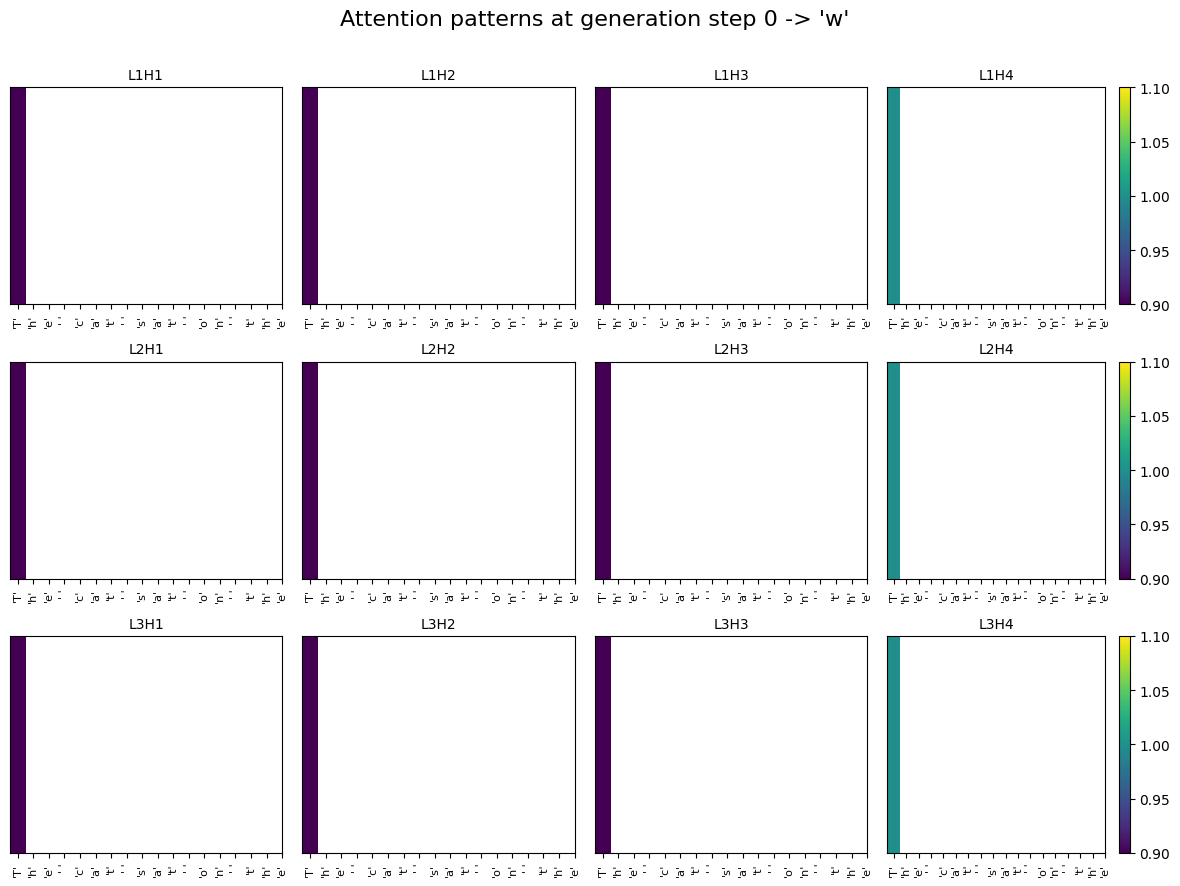

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_across_layers_and_heads(attention_weights, step_idx=0):
    """
    Plot attention weights across all layers and heads for a specific generation step.
    
    Args:
        attention_weights: List of attention weights from generate()
        step_idx: The generation step to visualize
    """
    if step_idx >= len(attention_weights):
        print(f"Step index {step_idx} is out of range. Max: {len(attention_weights)-1}")
        return
    
    step_attention = attention_weights[step_idx]
    n_layers = len(step_attention)
    
    # Get the first layer's attention to determine number of heads
    first_layer_attention = step_attention[0]
    if first_layer_attention.ndim < 2:
        print("Unexpected attention shape. Cannot determine number of heads.")
        return
    
    # For KV cache, shape is (batch, heads, 1, seq_len)
    if first_layer_attention.ndim == 4:
        n_heads = first_layer_attention.shape[1]
    else:
        n_heads = first_layer_attention.shape[0]
    
    # Prepare the combined figure
    fig, axes = plt.subplots(n_layers, n_heads, figsize=(n_heads*3, n_layers*3))
    
    # Handle the case when there's only one layer or one head
    if n_layers == 1 and n_heads == 1:
        axes = np.array([[axes]])
    elif n_layers == 1:
        axes = np.array([axes])
    elif n_heads == 1:
        axes = np.array([[ax] for ax in axes])
    
    # Input tokens up to this point (prompt + previously generated)
    input_tokens = [c for c in prompt]
    for i in range(step_idx):
        # Add generated tokens up to this step
        if i < len(generated_text) - len(prompt):
            input_tokens.append(generated_text[len(prompt) + i])
    
    # Add the token being generated (for the title)
    current_token = ""
    if step_idx < len(generated_text) - len(prompt):
        current_token = generated_text[len(prompt) + step_idx]
    
    # Plot each attention head
    for layer_idx in range(n_layers):
        layer_attention = step_attention[layer_idx]
        
        for head_idx in range(n_heads):
            ax = axes[layer_idx][head_idx]
            
            # Extract attention weights for this head
            # For KV cache, shape is (batch, heads, 1, seq_len)
            if layer_attention.ndim == 4:
                head_weights = layer_attention[0, head_idx, 0, :len(input_tokens)]
            else:
                head_weights = layer_attention[head_idx, -1, :len(input_tokens)]
            
            # Plot as a heatmap
            im = ax.imshow(
                head_weights[np.newaxis, :], 
                cmap='viridis', 
                aspect='auto'
            )
            
            # Set x-axis labels (input tokens)
            ax.set_xticks(np.arange(len(input_tokens)))
            ax.set_xticklabels([repr(t) for t in input_tokens], rotation=90, fontsize=8)
            
            # Hide y-axis ticks
            ax.set_yticks([])
            
            # Set title
            ax.set_title(f"L{layer_idx+1}H{head_idx+1}", fontsize=10)
            
            # Add colorbar
            if head_idx == n_heads-1:
                plt.colorbar(im, ax=ax)
    
    # Add a main title
    token_info = f" -> '{current_token}'" if current_token else ""
    fig.suptitle(f"Attention patterns at generation step {step_idx}{token_info}", fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Make room for the title
    plt.show()

# Plot attention for first generated token
plot_attention_across_layers_and_heads(attention_weights, step_idx=0)

## 9. Training on Custom Dataset

This cell demonstrates how to prepare and train the model on a custom dataset

In [42]:
import numpy as np
import os
import sys

# Adjust sys.path if the notebook is in 'notebooks/' and src is a sibling directory
# This allows importing modules from the 'src' directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.tokenizer import Tokenizer
from src.dataset import load_text_dataset, preprocess_dataset
from src.training_loop import prepare_batch # Assuming prepare_batch is accessible
                                         # or you can copy its definition here if preferred
from src.config import get_config # For parameters like max_seq_len

print("--- Demonstrating Dataset Preparation and Batching ---")

# 1. Define and save a sample text dataset
sample_text_content = """This is the first sentence for our demo.
It contains multiple lines and will be used to showcase dataset loading.
The quick brown fox jumps over the lazy dog.
We need enough text to form a few sequences for batching.
Let's add one more line to be safe.
"""
temp_dataset_file = "demo_sample_dataset.txt"

try:
    with open(temp_dataset_file, 'w', encoding='utf-8') as f:
        f.write(sample_text_content)
    print(f"1. Sample dataset created at: {temp_dataset_file}")
    print(f"   Content:\\n{sample_text_content[:100]}...\\n") # Print a snippet

    # 2. Initialize Tokenizer
    # For the demo, we'll build the tokenizer vocab from the sample text itself.
    # In a real scenario, you'd use a larger, pre-defined corpus.
    tokenizer = Tokenizer(sample_text_content)
    print(f"2. Tokenizer initialized.")
    print(f"   Vocabulary size: {tokenizer.vocab_size}")
    print(f"   First 10 chars in vocab: {''.join(tokenizer.chars[:10])}...\\n")

    # 3. Load dataset using load_text_dataset
    loaded_text = load_text_dataset(temp_dataset_file)
    print(f"3. Dataset loaded using load_text_dataset.")
    assert loaded_text == sample_text_content, "Content mismatch after loading!"
    print(f"   Successfully loaded {len(loaded_text)} characters.\\n")

    # 4. Preprocess dataset (tokenize)
    tokenized_data = preprocess_dataset(loaded_text, tokenizer)
    print(f"4. Dataset preprocessed (tokenized).")
    print(f"   Total tokens: {len(tokenized_data)}")
    print(f"   First 20 tokens: {tokenized_data[:20]}...\\n")

    # 5. Prepare a batch using prepare_batch
    # Use some config parameters (can be defaults or from get_config)
    config = get_config() # Using default config for demo purposes
    demo_batch_size = 2
    demo_seq_len = 10 # Make sure this is reasonable for the sample_text_content length
    
    print(f"5. Preparing a batch with batch_size={demo_batch_size}, seq_len={demo_seq_len}")

    if len(tokenized_data) < demo_seq_len + 1:
        print(f"   WARNING: Tokenized data length ({len(tokenized_data)}) is too short for seq_len ({demo_seq_len}). Batch preparation might fail or produce empty results.")
        inputs = np.array([])
        targets = np.array([])
    else:
        inputs, targets = prepare_batch(tokenized_data, demo_batch_size, demo_seq_len, current_idx=0)
    
    print(f"   Input batch shape: {inputs.shape}")
    print(f"   Target batch shape: {targets.shape}\\n")

    if inputs.size > 0:
        print("   Sample from the batch:")
        print(f"   Input [0] (first 10 tokens): {inputs[0][:10]}")
        print(f"   Target[0] (first 10 tokens): {targets[0][:10]}")
        # You can decode to verify:
        # print(f"   Decoded Input [0]: '{tokenizer.decode(list(inputs[0]))}'")
        # print(f"   Decoded Target[0]: '{tokenizer.decode(list(targets[0]))}'")
        
        # Verify relationship for the first item in the batch
        if demo_batch_size > 0 and demo_seq_len > 0 :
             assert np.array_equal(inputs[0, 1:], targets[0, :-1]), "Input/Target relationship error in demo batch!"
             print("\\n   Successfully verified input[0, 1:] == target[0, :-1]")


except Exception as e:
    print(f"An error occurred during the demo: {e}")
    import traceback
    traceback.print_exc()
finally:
    # 6. Clean up the temporary file
    if os.path.exists(temp_dataset_file):
        os.remove(temp_dataset_file)
        print(f"\\n6. Cleaned up temporary file: {temp_dataset_file}")

print("\\n--- End of Dataset Preparation and Batching Demo ---")

--- Demonstrating Dataset Preparation and Batching ---
1. Sample dataset created at: demo_sample_dataset.txt
   Content:\nThis is the first sentence for our demo.
It contains multiple lines and will be used to showcase dat...\n
2. Tokenizer initialized.
   Vocabulary size: 34
   First 10 chars in vocab: 
 '.ILTWab...\n
3. Dataset loaded using load_text_dataset.
   Successfully loaded 253 characters.\n
4. Dataset preprocessed (tokenized).
   Total tokens: 253
   First 20 tokens: [6, 15, 16, 26, 1, 16, 26, 1, 27, 15, 12, 1, 13, 16, 25, 26, 27, 1, 26, 12]...\n
5. Preparing a batch with batch_size=2, seq_len=10
   Input batch shape: (2, 10)
   Target batch shape: (2, 10)\n
   Sample from the batch:
   Input [0] (first 10 tokens): [ 6 15 16 26  1 16 26  1 27 15]
   Target[0] (first 10 tokens): [15 16 26  1 16 26  1 27 15 12]
\n   Successfully verified input[0, 1:] == target[0, :-1]
\n6. Cleaned up temporary file: demo_sample_dataset.txt
\n--- End of Dataset Preparation and Batching Demo ---

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from src.config import get_config
from src.tokenizer import Tokenizer
from src.decoder import Decoder
from src.dataset import load_text_dataset, preprocess_dataset
from src.training_loop import train

# Define a small custom training corpus
print("Creating a small custom training corpus...")
custom_corpus = """
In the quiet village nestled between rolling hills, there lived a curious child named Lily. 
Every day, she would explore the meadows and forests surrounding her home, collecting flowers and interesting rocks.
One day, she ventured deeper into the forest than ever before and discovered an old, forgotten path.
The path led to a small clearing where stood an ancient oak tree, its branches reaching toward the sky like outstretched arms.
Beneath the tree was a small wooden chest, partially buried in the earth.
"""

# Save corpus to a temporary file
import tempfile
import os
temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.txt')
temp_file.write(custom_corpus.encode('utf-8'))
temp_file_path = temp_file.name
temp_file.close()
print(f"Saved corpus to temporary file: {temp_file_path}")

# Load and preprocess the dataset
loaded_text = load_text_dataset(temp_file_path)
print(f"Loaded {len(loaded_text)} characters from the file")
tokenizer = Tokenizer(loaded_text)
print(f"Created tokenizer with vocabulary size: {tokenizer.vocab_size}")
tokens = preprocess_dataset(loaded_text, tokenizer)
print(f"Preprocessed dataset contains {len(tokens)} tokens")

# Get a small configuration for quick demonstration
config = get_config()
small_config = {
    'd_model': 32,       # Reduced from typical 512
    'n_layers': 2,       # Reduced from typical 6-12
    'n_heads': 2,        # Reduced from typical 8-16
    'd_ff': 64,          # Reduced from typical 2048
    'dropout_rate': 0.1,
    'max_seq_len': 100,
    'vocab_size': tokenizer.vocab_size,
    'batch_size': 2,
    'seq_len': 10,
    'learning_rate': 0.001,
    'epochs': 1          # Set epochs here instead of as a parameter
}

# Create a small model
print("Creating a small model for training demonstration...")
small_model = Decoder(
    d_model=small_config['d_model'],
    n_layers=small_config['n_layers'],
    n_heads=small_config['n_heads'],
    d_ff=small_config['d_ff'],
    max_seq_len=small_config['max_seq_len'],
    vocab_size=small_config['vocab_size'],
    dropout_rate=small_config['dropout_rate']
)

# Create a small batch for demonstration
batch_size = small_config['batch_size']
seq_len = small_config['seq_len']

# Create example batch for demonstration
import numpy as np
print(f"\nExample batch (size={batch_size}, seq_len={seq_len}):")
example_batch_x = np.array([tokens[i:i+seq_len] for i in range(0, len(tokens)-seq_len-1, seq_len)][:batch_size])
example_batch_y = np.array([tokens[i+1:i+seq_len+1] for i in range(0, len(tokens)-seq_len-1, seq_len)][:batch_size])

for i in range(batch_size):
    input_text = tokenizer.decode(example_batch_x[i].tolist())
    target_text = tokenizer.decode(example_batch_y[i].tolist())
    print(f"  Batch item {i+1}:")
    print(f"    Input:  '{input_text}'")
    print(f"    Target: '{target_text}'")
    print(f"    Note that target[i] is the next token after input[i]")

print("\nRunning a minimal training process (just to demonstrate)...")

try:
    # Limit to very few batches for demonstration
    # Ensure this is how you call train:
    loss_history = train(
    model=small_model,
    tokenizer_instance=tokenizer,
    corpus=loaded_text,  # Pass the raw string corpus here
    epochs=small_config['epochs'],
    batch_size=small_config['batch_size'],
    learning_rate=small_config['learning_rate'],
    seq_len=small_config['seq_len']
    # print_every uses its default value, so it's optional
)
    
except Exception as e:
    print(f"Error during training demonstration: {e}")
    print("This is expected if your implementation is incomplete or focuses only on inference.")

# Clean up temporary file
os.unlink(temp_file_path)
print(f"Removed temporary file: {temp_file_path}")

Creating a small custom training corpus...
Saved corpus to temporary file: /var/folders/1p/nzdyb17d31g3804_8gj2fqmc0000gr/T/tmpfp_fr2j2.txt
Loaded 513 characters from the file
Created tokenizer with vocabulary size: 34
Preprocessed dataset contains 513 tokens
Creating a small model for training demonstration...

Example batch (size=2, seq_len=10):
  Batch item 1:
    Input:  '
In the qu'
    Target: 'In the qui'
    Note that target[i] is the next token after input[i]
  Batch item 2:
    Input:  'iet villag'
    Target: 'et village'
    Note that target[i] is the next token after input[i]

Running a minimal training process (just to demonstrate)...
Starting training with: epochs=1, batch_size=2, lr=0.001, seq_len=10
  Corpus length: 513 tokens
  Vocab size: 34
  Effective number of batches per epoch: 251
  Epoch 1/1, Batch 100/251, Avg Batch Loss: 3.5389
  Epoch 1/1, Batch 200/251, Avg Batch Loss: 3.0379
  Epoch 1/1, Batch 251/251, Avg Batch Loss: 2.9106
Epoch 1 completed. Average Epoc

## 10. Theoretical Understanding of KV Cache

The Key-Value (KV) Cache is a technique to optimize the autoregressive generation process in transformer-based models. Here's a brief explanation of how it works:

### Standard Generation (Without KV Cache)
- For each new token to generate, the model processes the entire sequence of tokens generated so far
- Computational complexity: O(n²) where n is the sequence length
- As the sequence grows, generation gets progressively slower

### Generation with KV Cache
- Key and Value projections for previously processed tokens are stored and reused
- For each new token, only the new token needs to be processed, and its K, V are appended to the cache
- Computational complexity: O(n) where n is the sequence length
- Generation time per token remains approximately constant

### Benefits of KV Cache
1. **Efficiency**: Dramatically reduces computation for long sequences
2. **Speed**: As demonstrated above, provides significant speedup
3. **Memory Usage**: Trades increased memory usage for computational efficiency